## Setup

In [1]:
%load_ext autoreload
%autoreload 2

########################################################
# python
import numpy as np
import scipy.stats
norm = scipy.stats.norm

########################################################
# xgboost, sklearn
import xgboost as xgb

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve

########################################################
# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', message='Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.')

########################################################
# set global rnd_seed for reproducability
rnd_seed = 42
np.random.seed(rnd_seed)

In [2]:
from plotting import * # load plotting code

In [3]:
inline=True # plot inline or to pdf
output = './output' # output dir

***
# ROC Curve Demo
A demonstration of TPR vs FPR and Precision vs Recall ROC curves on a synthetic dataset with XGBoost

## Generate Random Data

In [4]:
X, y = make_classification(n_samples=int(1e5), n_features=50, n_informative=20, n_redundant=10, n_repeated=2,
                           n_classes=2, n_clusters_per_class=5, weights=[0.7], flip_y=0.2, class_sep=0.9,
                           hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=rnd_seed)

Make Train, Validation, and Holdout Sets

In [5]:
X_trainVal, X_holdout, y_trainVal, y_holdout = train_test_split(X, y, test_size=0.33, random_state=rnd_seed, stratify=y)
del X; del y;

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.2, random_state=rnd_seed, stratify=y_trainVal)
del X_trainVal; del y_trainVal;

#### Set hyperparameters

In [6]:
params_default = {'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 1.0}

In [7]:
params_bad = {'max_depth': 2, 'learning_rate': 1.0, 'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 0.0}

In [8]:
fixed_setup_params = {
'max_num_boost_rounds': 500, # maximum number of boosting rounds to run / trees to create
'xgb_objective': 'binary:logistic', # objective function for binary classification
'xgb_verbosity': 0, #  The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
'xgb_n_jobs': -1, # Number of parallel threads used to run XGBoost. -1 makes use of all cores in your system
}

In [9]:
fixed_fit_params = {
    'early_stopping_rounds': 10, # must see improvement over last num_early_stopping_rounds or will halt
    'eval_set': [(X_val, y_val)], # data sets to use for early stopping evaluation
    'eval_metric': 'auc', # evaluation metric for early stopping
    'verbose': False, # even more verbosity control
}

## Setup XGBClassifiers
#### Run with initial hyperparameters as a baseline

In [10]:
model_default = xgb.XGBClassifier(n_estimators=fixed_setup_params['max_num_boost_rounds'],
                                  objective=fixed_setup_params['xgb_objective'],
                                  verbosity=fixed_setup_params['xgb_verbosity'],
                                  random_state=rnd_seed+3, **params_default, use_label_encoder=False)
model_default.fit(X_train, y_train, **fixed_fit_params);

#### Run with bad hyperparameters to compare

In [11]:
model_bad = xgb.XGBClassifier(n_estimators=round(0.25*fixed_setup_params['max_num_boost_rounds']),
                                  objective=fixed_setup_params['xgb_objective'],
                                  verbosity=fixed_setup_params['xgb_verbosity'],
                                  random_state=rnd_seed+4, **params_bad, use_label_encoder=False)
model_bad.fit(X_train, y_train, **fixed_fit_params);

## Evaluate

In [12]:
y_holdout_pred_default = model_default.predict_proba(X_holdout, iteration_range=(0, model_default.best_iteration+1))[:,1]
fpr_default, tpr_default, thr_default = roc_curve(y_holdout, y_holdout_pred_default)
precision_default, recall_default, thr2_default = precision_recall_curve(y_holdout, y_holdout_pred_default)

y_holdout_pred_bad = model_bad.predict_proba(X_holdout, iteration_range=(0, model_bad.best_iteration+1))[:,1]
fpr_bad, tpr_bad, thr_bad = roc_curve(y_holdout, y_holdout_pred_bad)
precision_bad, recall_bad, thr2_bad = precision_recall_curve(y_holdout, y_holdout_pred_bad)

models_for_roc= [
    {'name': 'model_1', 'nname': 'Model 1', 'fpr': fpr_default, 'tpr': tpr_default,
     'pre': precision_default, 'rec':recall_default, 'c': 'C2', 'ls': '-'},
    {'name': 'model_2', 'nname': 'Model 2', 'fpr': fpr_bad, 'tpr': tpr_bad,
     'pre': precision_bad, 'rec':recall_bad, 'c': 'black', 'ls': '--'},
]

In [13]:
pop_PPV = len(np.where(y_holdout == 1)[0]) / len(y_holdout) # P / (P + N)

### Standard TPR vs FPR ROC

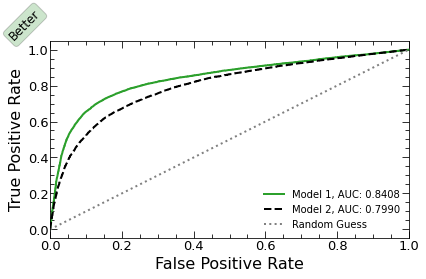

In [14]:
plot_rocs(models_for_roc, m_path=output, rndGuess=True, inverse_log=False, inline=inline)

#### Inverse Log TPR vs FPR ROC

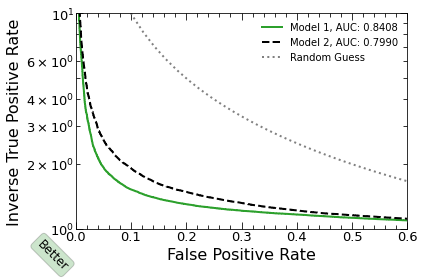

In [15]:
plot_rocs(models_for_roc, m_path=output, rndGuess=True, inverse_log=True,
          x_axis_params={'max': 0.6}, y_axis_params={'min': 1e0, 'max': 1e1}, inline=inline)

### Precision vs Recall ROC

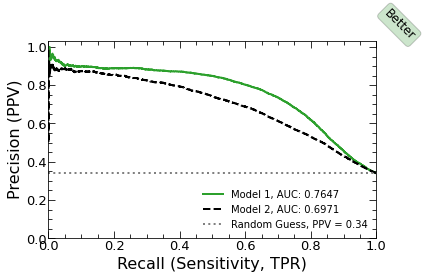

In [16]:
plot_rocs(models_for_roc, m_path=output, rndGuess=True, inverse_log=False, precision_recall=True, pop_PPV=pop_PPV,
          y_axis_params={'min': 0.0}, inline=inline)

#### Inverse Log Precision vs Recall ROC

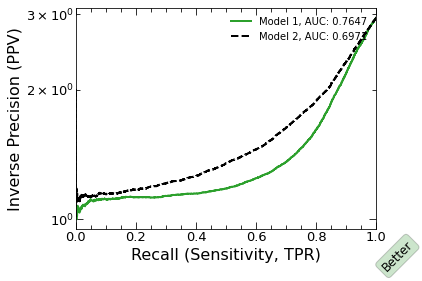

In [17]:
plot_rocs(models_for_roc, m_path=output, rndGuess=False, inverse_log=True, precision_recall=True, pop_PPV=pop_PPV, inline=inline)

### Precision vs Recall ROC with F1 and TP + FP TODO

***
# Hypothesis Testing Power Example

In [18]:
Z_a = norm.ppf(1-0.05) + np.sqrt(100)*(10-10.5)/2
print(f'Z_a = {Z_a:.4f}')
print(f'Power = 1-beta = {1-norm.cdf(Z_a):.4f}')

Z_a = -0.8551
Power = 1-beta = 0.8038


***
# inverse_transform_sampling_normal_dist
Adapted from https://commons.wikimedia.org/wiki/File:Inverse_transform_sampling.png

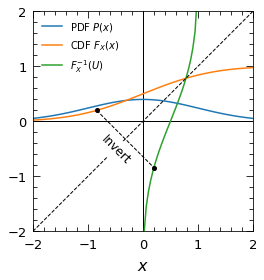

In [19]:
norm = scipy.stats.norm
x = np.linspace(-2, 2, 100)

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axhline(y=0, color='k', lw=1)
ax.axvline(x=0, color='k', lw=1)

ax.set_xlim([-2.,2.])
ax.set_ylim([-2.,2.])
ax.set_xlabel('$x$', labelpad=7)

ax.plot(x, norm.pdf(x), label=r'PDF $P(x)$')
ax.plot(x, norm.cdf(x), label=r'CDF $F_{X}(x)$')
ax.plot(x, norm.ppf(x), label='$F^{-1}_{X}(U)$')
ax.plot(x,x,'--k', lw=1)
ax.plot([norm.ppf(0.2),0.2],[0.2,norm.ppf(0.2)],'o--k', ms=4, lw=1)

ax.xaxis.set_ticks(np.arange(-2, 3, 1))
ax.yaxis.set_ticks(np.arange(-2, 3, 1))

plt.text(-0.5, -0.5, 'Invert', size=12, rotation=-45, horizontalalignment='center', verticalalignment='center', bbox=dict(edgecolor='white', facecolor='white', alpha=1))

dx = 0/72.; dy = -5/72. 
offsetx = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
offsety = matplotlib.transforms.ScaledTranslation(dy, dx, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offsetx)
for label in ax.yaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offsety)
    
leg = ax.legend(loc='upper left',frameon=False)
leg.get_frame().set_facecolor('none')

plt.tight_layout()
if inline:
    fig.show()      
else:
    os.makedirs(output, exist_ok=True)
    fig.savefig(f'{output}/inverse_transform_sampling_normal_dist.pdf')
    plt.close('all')

***
# rejection_sampling
Adapted from https://www.data-blogger.com/2016/01/24/the-mathematics-behind-rejection-sampling/

In [20]:
# The multiplication constant to make our probability estimation fit
M = 3
# Number of samples to draw from the probability estimation function
N = 5000

# The target probability density function
f = lambda x: 0.6 * norm.pdf(x, 0.35, 0.05) + 0.4 * norm.pdf(x, 0.65, 0.08)

# The approximated probability density function
g = lambda x: norm.pdf(x, 0.45, 0.2)

# A number of samples, drawn from the approximated probability density function
np.random.seed = 42
x_samples = M * np.random.normal(0.45, 0.2, (N,))

# A number of samples in the interval [0, 1]
u = np.random.uniform(0, 1, (N, ))

# Now examine all the samples and only use the samples found by rejection sampling
samples = [(x_samples[i], u[i] * M * g(x_samples[i])) for i in range(N) if u[i] < f(x_samples[i]) / (M * g(x_samples[i]))]

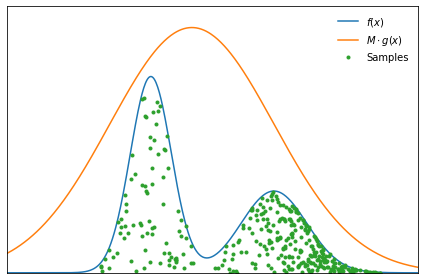

In [21]:
fig, ax = plt.subplots()
# ax.set_aspect('equal')
# ax.axhline(y=0, color='k', lw=1)
# ax.axvline(x=0, color='k', lw=1)

ax.set_xlim([0.,1.])
ax.set_ylim([0.,6.5])
# ax.axis('off')
# ax.set_xlabel('$x$', labelpad=7)

ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False)

# ax.xaxis.set_ticks(np.arange(-2, 3, 1))
# ax.yaxis.set_ticks(np.arange(-2, 3, 1))

x = np.linspace(0, 1, 500)

ax.plot(x, f(x), '-', label='$f(x)$')
ax.plot(x, M * g(x), '-', label='$M \cdot g(x)$')

ax.plot([sample[0] for sample in samples], [sample[1] for sample in samples], '.', label='Samples')

# dx = 0/72.; dy = -5/72. 
# offsetx = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# offsety = matplotlib.transforms.ScaledTranslation(dy, dx, fig.dpi_scale_trans)
# for label in ax.xaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offsetx)
# for label in ax.yaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offsety)
    
leg = ax.legend(loc='upper right',frameon=False)
leg.get_frame().set_facecolor('none')

plt.tight_layout()
if inline:
    fig.show()
else:
    os.makedirs(output, exist_ok=True)
    fig.savefig(f'{output}/rejection_sampling.pdf')
    plt.close('all')

***
# Hypergeometric PMF
Adapted from https://en.wikipedia.org/wiki/File:HypergeometricPDF.png and https://en.wikipedia.org/wiki/File:Geometric_pmf.svg

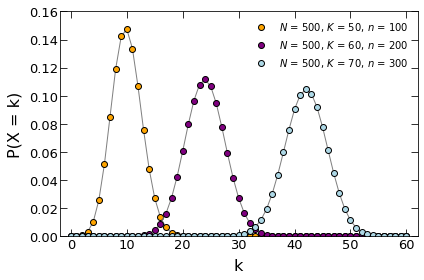

In [22]:
fig, ax = plt.subplots()

ax.tick_params(
    axis='both',
    which='minor',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelleft=True,
    labelbottom=True)

x = np.linspace(0, 60, 61)

# (N, K, n)
params = [
    [500, 50, 100],
    [500, 60, 200],
    [500, 70, 300],
]

colors = ['orange', 'purple', 'lightblue']

for param, color in zip(params, colors):
    pmf = scipy.stats.hypergeom(*param).pmf(x)
    ax.plot(x, pmf, '-', c='grey', lw=1)
    ax.plot(x, pmf, 'o', c=color, markeredgecolor='black', lw=3, label=f'$N$ = {param[0]}, $K$ = {param[1]}, $n$ = {param[2]}')

ax.set_xlim([-2.,62.])
ax.set_ylim([0.,0.16])
ax.set_xlabel('k', labelpad=7)
ax.set_ylabel('P(X = k)', labelpad=7)

leg = ax.legend(loc='upper right',frameon=False)
leg.get_frame().set_facecolor('none')

plt.tight_layout()
if inline:
    fig.show()
else:
    os.makedirs(output, exist_ok=True)
    fig.savefig(f'{output}/hypergeometric_pmf.pdf')
    plt.close('all')

***
# Spearman Correlation
Addapted from https://en.wikipedia.org/wiki/File:Spearman_fig1.svg and https://en.wikipedia.org/wiki/File:Spearman_fig3.svg

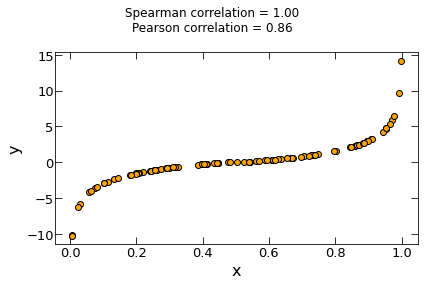

In [23]:
fig, ax = plt.subplots()

ax.tick_params(
    axis='both',
    which='minor',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelleft=True,
    labelbottom=True)

rnd_state = np.random.RandomState(43)
x = rnd_state.uniform(size=100)
y = np.log(x/(1-x))
y = np.sign(y)*np.abs(y)**1.4

Rx = np.argsort(np.argsort(x))
Ry = np.argsort(np.argsort(y))

cs = np.cov(Rx,Ry)
cs = cs[0,1]/np.sqrt(cs[0,0]*cs[1,1])

cp = np.cov(x,y)
cp = cp[0,1]/np.sqrt(cp[0,0]*cp[1,1])

ax.plot(x, y, 'o', color='orange', markeredgecolor='black', lw=3)
fig.suptitle(f'Spearman correlation = {cs:.2f}\nPearson correlation = {cp:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()
if inline:
    fig.show()
else:
    os.makedirs(output, exist_ok=True)
    fig.savefig(f'{output}/spearman_corr_non_para.pdf')
    plt.close('all')

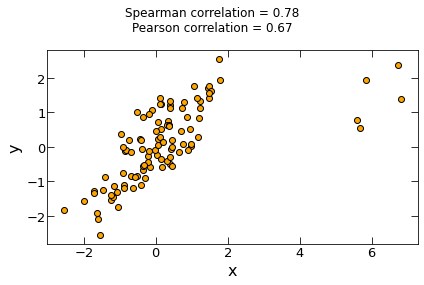

In [24]:
fig, ax = plt.subplots()

ax.tick_params(
    axis='both',
    which='minor',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelleft=True,
    labelbottom=True)

r = 0.8

rnd_state = np.random.RandomState(0)
x = rnd_state.normal(size=100)
y = r*x + np.sqrt(1-r**2)*rnd_state.normal(size=100)

ii = np.argsort(-x)
x[ii[0:5]] *= 3

Rx = np.argsort(np.argsort(x))
Ry = np.argsort(np.argsort(y))

cs = np.cov(Rx,Ry)
cs = cs[0,1]/np.sqrt(cs[0,0]*cs[1,1])

cp = np.cov(x,y)
cp = cp[0,1]/np.sqrt(cp[0,0]*cp[1,1])

ax.plot(x, y, 'o', color='orange', markeredgecolor='black', lw=3)
fig.suptitle(f'Spearman correlation = {cs:.2f}\nPearson correlation = {cp:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()
if inline:
    fig.show()
else:
    os.makedirs(output, exist_ok=True)
    fig.savefig(f'{output}/spearman_corr_outliers.pdf')
    plt.close('all')